# Image and Video analysis

One of my interests is exploring computer vision libraries and understanding how to apply them to real work tasks.
For a newcomer to the field a simple pipeline may be easier to think of than to implement.
Also reading in video files and segmenting them could be a task that one may have to do as a data scientist. 
Anyone reading about machine learning algorithms and going through online videos can come to the realization that such a task is achievable today. Yet in my experience these algorithims could be tricky to implement well in practice. It is very useful and easy to leverage opensource libraries like OpenCV to simply or speed up processing tasks. Similarly libraries like Keras and PyTorch make it easier to implement deep learning algorithms with convenience Python. 
The latest release of OpenCV makes significant leaps. 

This notebook uses OpenCV to read and manipulate video data.


Here is a link to more information: http://opencv.org/opencv-3-3.html

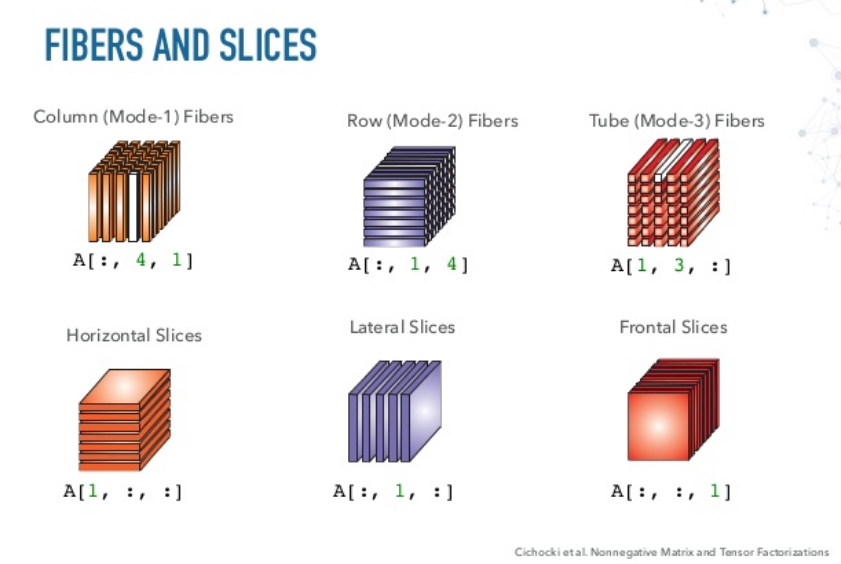

In [14]:
from IPython.display import Image
Image(filename='andre_panisson_pydata.png') 

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pims
from skimage import segmentation, color

%matplotlib inline
cv2.__version__

'3.2.0'

Original slide:
https://www.slideshare.net/panisson/exploring-temporal-graph-data-with-python-a-study-on-tensor-decomposition-of-wearable-sensor-data

### Grab an frame from the video:

Frame([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
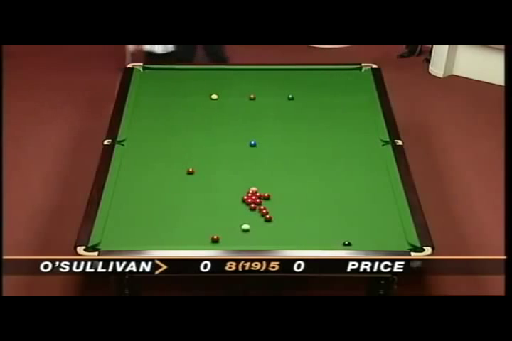

In [31]:
v = pims.Video('../snooker_clip.mp4')
v[200]

PIMS is a library that makes it easy to easy in video files and look at frames.
https://github.com/soft-matter/pims

Next step is looking at slices and explore useful filters.

In [38]:
img = np.array(v[200])

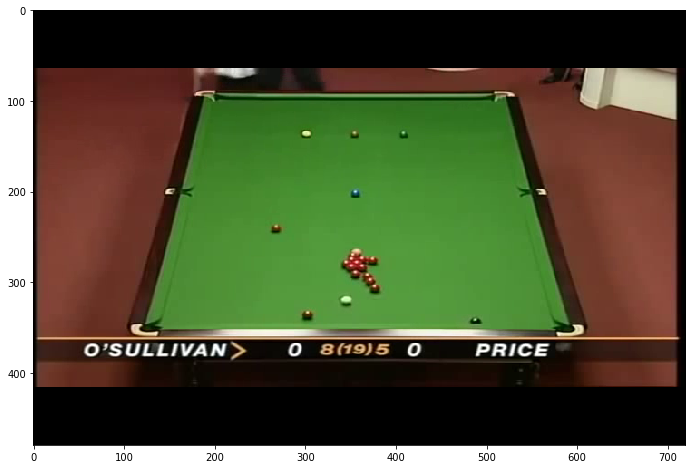

In [40]:
plt.figure(figsize=(12,8))
plt.imshow(img)

## Looking at slices across the image:
An image can be thought of a strings of numbers of as stacked sheets of numbers or a 3 dimensional volume. 
The 3 dimensions(or channels) are Red, Green and Blue if the image is in the RGB colorspace.
Each of these dimensions is composed an array of numbers(integers between 0-255 or floats between 0 and 1) that give pixel values of the red, green and blue channels at different locations in the image.
A easy way to understand this is to look at slices across the image.

In [34]:
def plot_intensity(img,row=None,col=None):
    if row:
        
        r = img[row,:,0]
        g = img[row,:,1]
        b = img[row,:,2]
    
    if col:
        
        r = img[:,col,0]
        g = img[:,col,1]
        b = img[:,col,2]
        
    
    plt.figure(figsize=(12,8))
    plt.plot(r,'r')
    plt.plot(g,'g')
    plt.plot(b,'b')

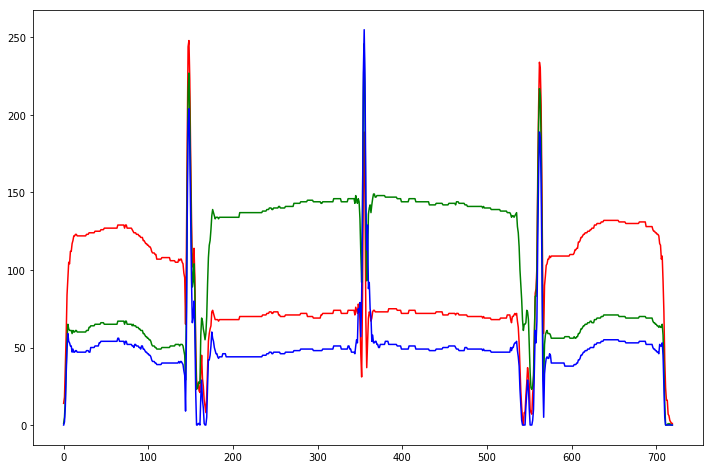

In [44]:
plot_intensity(img,row=200)

While looking across the image at row 200. Once can see the three spikes. The middle spike is the blue ball at the center of the table and the other two spikes are the two middle pockets of the snooker table.
Once can also notice the green color of the table is captured between the two pockets.

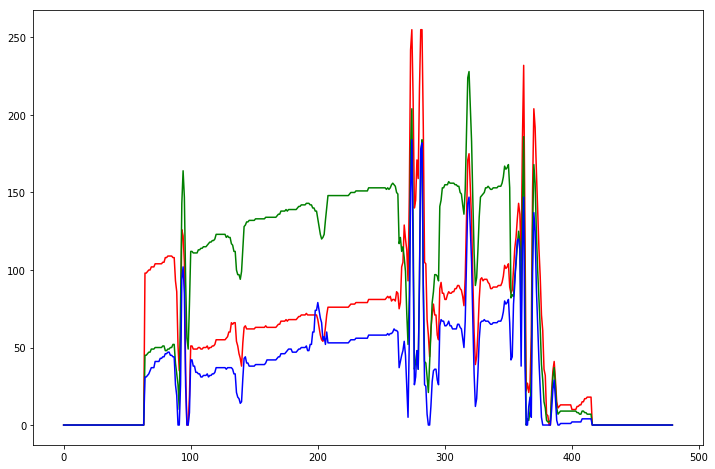

In [60]:
plot_intensity(img,col=350)

Looking at a column slice at pixel 350 one can notice the distortion in the pixels because of the perspective of the video. There is a clumping of pixel data closer to the far end of the table. In the graph above one can notice a spike in the blue line close to x value of 200, that is the blue ball at the center of the table. 

## Segmentation using scikit-image:

To identify individual objects in a image one has to segment them for the background and other objects.
There are many segmenation routines that accomplish this task. The first step is remove distortion in the image.
An transforming the image using an affine transformation in opencv is a way to accomplish this task.

The code below resizes the image, picks the four corner pockets(pts1) and transforms them to destination locations(pts2).

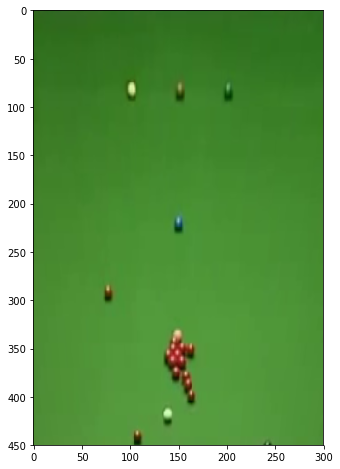

In [79]:
resized = cv2.resize(img,(400,400),interpolation=cv2.INTER_AREA)
pts1 = np.float32([[110,85],[280,85],[85,285],[315,285]])
pts2 = np.float32([[0,0],[300,0],[0,450],[300,450]])
    
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(resized,M,(300,450))
plt.figure(figsize=(12,8))
plt.imshow(dst)

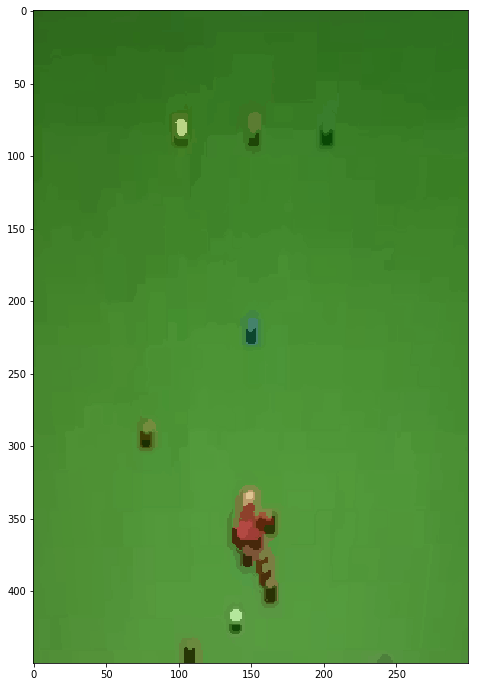

In [80]:
felzenszwalb = segmentation.felzenszwalb(dst, scale=10)
plt.figure(figsize=(12,12))
plt.imshow(color.label2rgb(felzenszwalb, dst, kind='mean'))

Above I applied the felzenszwalb filter from the segmentation module in scikit-image. 
There are number of options availble in the scikit-image:
http://scikit-image.org/docs/dev/api/skimage.segmentation.html

## Reading in video using OpenCV:

OpenCV is another great library for image and video analysis. The latest version(3.3) allows implemention of custom neural networks in a deep learning library of choice and then slot them into OpenCV.
This code snippet reads in the video. The read() method the video class reads the video and outputs a frame.
A frame can be thought of as a image.

In [81]:
video = cv2.VideoCapture('../snooker_clip.mp4')
ret,frame =  video.read()
print(frame.shape)
video.release()

(480, 720, 3)


After removing as much of the distortion as possible from the original video.
An easy first step is to use a background subtractor. Removing the background could prove useful for tracking the motion of the balls. Also it might make sense to start with figuring out the location of the cue ball. The motion is very sharp when the cue hits the ball and this causes it stand out in the video. As a starting point OpenCV comes with several background image subtraction algorithms. The code below uses the K-Nearest Neighbors algorithm for background image subtraction. 
This does have caveats: Shadows also move with objects and this creates artifacts and there are algorithms that perform better of worse with different tasks.

If all the prerequiste libraries are install then this code should pop open a window and display the video. It does this by going through each in the stack of images and displaying them one by one on the screen.

In [93]:
import numpy as np
import cv2

video = cv2.VideoCapture('../snooker_clip.mp4')

#Function call to opencv background image subtractor
fgbg = cv2.createBackgroundSubtractorKNN()

#Video loop
while(video.isOpened()):
    ret, frame = video.read()
    resized = cv2.resize(frame,(400,400),interpolation=cv2.INTER_AREA)
    img = resized
    pts1 = np.float32([[110,85],[280,85],[85,285],[315,285]])
    pts2 = np.float32([[0,0],[300,0],[0,450],[300,450]])
    
    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(img,M,(300,450))
    hsv = cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
    
    fgmask = fgbg.apply(dst)
#     plt.imshow(fgmask)
    if ret == True:
            cv2.imshow('image',fgmask)
            k = cv2.waitKey(30) & 0xff
            if k == ord('q'):
                break
                
    else:
        break

video.release()
cv2.destroyAllWindows()

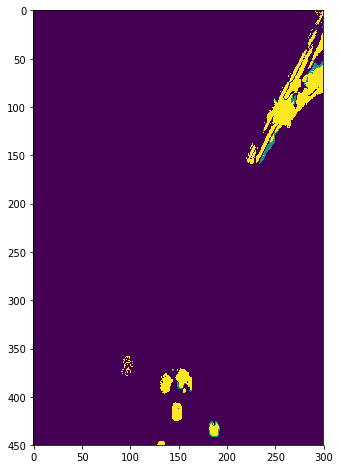

In [94]:
#This displays the last frame
plt.figure(figsize=(12,8))
plt.imshow(fgmask)


References:
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html
- pyimagesearch

### Notes:

- Explore contour segmentation on background separated video.
- Is it possible to identify each ball and print out the result on the screen?
- Is it possible to identify location of collisions?
- Is it possible to count the number of balls on the table?
